In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data = pd.read_csv("dataset_diabetes/diabetic_data.csv")
ID = pd.read_csv('dataset_diabetes/IDs_mapping.csv')

### Changing the IDs into 3 column format

In [4]:
IDs = pd.DataFrame(index = range(63), columns = ['ID_types', 'ID_num', 'Description'])

In [4]:
IDs.loc[:8, 'ID_types'] = ['admission_type_id'] * 9
IDs.loc[:8, 'ID_num'] = ID.loc[:8,'admission_type_id'].values
IDs.loc[:8, 'Description'] = ID.loc[:8,'description'].values

IDs.loc[8:38, 'ID_types'] = ['discharge_disposition_id'] * 31
IDs.loc[8:38, 'ID_num'] = ID.loc[10:40,'admission_type_id'].values
IDs.loc[8:38, 'Description'] = ID.loc[10:40,'description'].values

IDs.loc[38:, 'ID_types'] = ['admission_source_id'] * 25
IDs.loc[38:, 'ID_num'] = ID.loc[42:,'admission_type_id'].values
IDs.loc[38:, 'Description'] = ID.loc[42:,'description'].values

In [5]:
IDs.to_csv('IDs_clean.csv')

## Data Cleaning

In [3]:
# dropping the columns w/ more than 50% values missing
data.drop(['weight','medical_specialty'], axis = 1, inplace = True)

In [4]:
# replace the age range with the middle of the interval
replaceDict = {'[0-10)' : 5,'[10-20)' : 15, '[20-30)' : 25, 
               '[30-40)' : 35,'[40-50)' : 45,'[50-60)' : 55,
               '[60-70)' : 65,'[70-80)' : 75,'[80-90)' : 85,
               '[90-100)' : 95}

data['age'] = data['age'].apply(lambda x : replaceDict[x])
print(data['age'].head())

0     5
1    15
2    25
3    35
4    45
Name: age, dtype: int64


In [5]:
# removing duplicate records
print('Length before removing Duplicates:', len(data))
data.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)
print('Length after removing Duplicates:', len(data))

Length before removing Duplicates: 101766
Length after removing Duplicates: 71518


### Using domain knowledge on diag_1, diag_2, and diag_3 to bin the diagnosis
1. Circulatory → 390–459, 785 → Diseases of the circulatory system
2. Respiratory → 460–519, 786 → Diseases of the respiratory system
3. Digestive → 520–579, 787 → Diseases of the digestive system
4. Diabetes → 250.xx → Diabetes mellitus
5. Injury → 800–999 → Injury and poisoning
6. Musculoskeletal → 710–739 → Diseases of the musculoskeletal system and connective tissue
7. Genitourinary → 580–629, 788 → Diseases of the genitourinary system
8. Neoplasms → 140–239 → Neoplasms
9. Pregnecy → 630–679 → Complications of pregnancy, childbirth, and the puerperium
10. Other

In [6]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [7]:
def diag_transform(x):
    if str(x)[0] == 'V' or str(x)[0] == 'E':
        return 'other'
    elif isfloat(x):
        if int(float(x)) in range(390, 460) or int(float(x)) == 785:
            return 'circulatory'
        elif int(float(x)) in range(460, 520) or int(float(x)) == 786:
            return 'respiratory'
        elif int(float(x)) in range(520, 580) or int(float(x)) == 787:
            return 'digestive'
        elif int(float(x)) == 250:
            return'diabetes'
        elif int(float(x)) in range(800, 1000):
            return 'injury'
        elif int(float(x)) in range(710, 740):
            return 'musculoskeletal'
        elif int(float(x)) in range(580, 630) or int(float(x)) == 788:
            return 'genitourinary'
        elif int(float(x)) in range(140, 240):
            return 'neoplasms'
        elif int(float(x)) in range(630, 680):
            return 'pregnecy'
        else:
            return 'other'
    else:
        return 'other'

In [8]:
data['diag_1'] = data['diag_1'].apply(diag_transform)
data['diag_2'] = data['diag_2'].apply(diag_transform)
data['diag_3'] = data['diag_3'].apply(diag_transform)

### Using domain knowledge to bin admission_type_id, discharge_disposition_id, admission_source_id

In [9]:
data['admission_type_id'] = data['admission_type_id'].astype('int')
data['admission_source_id'] = data['admission_source_id'].astype('int')
data['discharge_disposition_id'] = data['discharge_disposition_id'].astype('int')

In [10]:
def ad_type_transform(x):
    if x in [2,7]:
        return 1
    elif x in [6,8]:
        return 5
    else:
        return x
    
def ad_source_transform(x):
    if x in [2,3]:
        return 1
    elif x in [5,6,10,22,25]:
        return 4
    elif x in [15,17,20,21]:
        return 9
    elif x in [13,14]:
        return 11
    else:
        return x
    
def discharge_transform(x):
    if x in [6, 8, 9, 13]:
        return 1
    elif x in [3, 4, 5, 14, 22, 23, 24]:
        return 2
    elif x in [12, 15, 16, 17]:
        return 10
    elif x in [19, 20, 21]:
        return 11
    elif x in [25, 26]:
        return 18
    elif x in [13,14,19,20,21]:
        return 11
    else:
        return x

In [11]:
data['admission_type_id'] = data['admission_type_id'].apply(ad_type_transform)
data['admission_source_id'] = data['admission_source_id'].apply(ad_source_transform)
data['discharge_disposition_id'] = data['discharge_disposition_id'].apply(discharge_transform)

### Change readmission to two levels instead of three
- Changing readmitted > 30 days to no
- Changing readmitted < 30 days to yes


In [12]:
data.readmitted.value_counts()

NO     42985
>30    22240
<30     6293
Name: readmitted, dtype: int64

In [13]:
data['readmitted'] = data['readmitted'].apply(lambda x: 0 if x == 'NO' or x == '>30'
                                              else 1)

### Creating number of changes variable
- number of 'ups' and 'downs' in medication

In [14]:
druglist = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide',
            'glimepiride','acetohexamide', 'glipizide', 'glyburide', 
            'tolbutamide','pioglitazone', 'rosiglitazone', 'acarbose', 
            'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 
            'insulin', 'glyburide-metformin', 'glipizide-metformin',
            'glimepiride-pioglitazone', 'metformin-rosiglitazone',
            'metformin-pioglitazone']

In [15]:
num_of_changes = []
for i in tqdm(range(len(data))) :
    changeCount = 0
    for col in druglist : 
        if data.iloc[i][col] in ['Down', 'Up'] :
            changeCount += 1
    num_of_changes.append(changeCount)

100%|████████████████████████████████████| 71518/71518 [01:30<00:00, 788.14it/s]


In [16]:
data['num_of_changes'] = num_of_changes

### Imputing Missing Values in Race
by drawing randomly from the race in the observations

In [18]:
import random

In [19]:
races = data['race'].loc[data['race'] != '?'].values
data['race'].value_counts()

Caucasian          53491
AfricanAmerican    12887
?                   1948
Hispanic            1517
Other               1178
Asian                497
Name: race, dtype: int64

In [20]:
data['race'] = data['race'].apply(lambda x: random.choice(races) if x == '?' else x)
data['race'].value_counts()

Caucasian          55000
AfricanAmerican    13225
Hispanic            1572
Other               1217
Asian                504
Name: race, dtype: int64

In [21]:
# re_indexing
data.index = np.arange(0,len(data))

In [22]:
data.to_csv('diabetes_cleaned.csv')

### EDA

In [22]:
data_plot = data[['time_in_hospital','num_lab_procedures','num_procedures',
                  'num_medications','number_emergency','number_outpatient', 
                   'number_inpatient','number_diagnoses']]

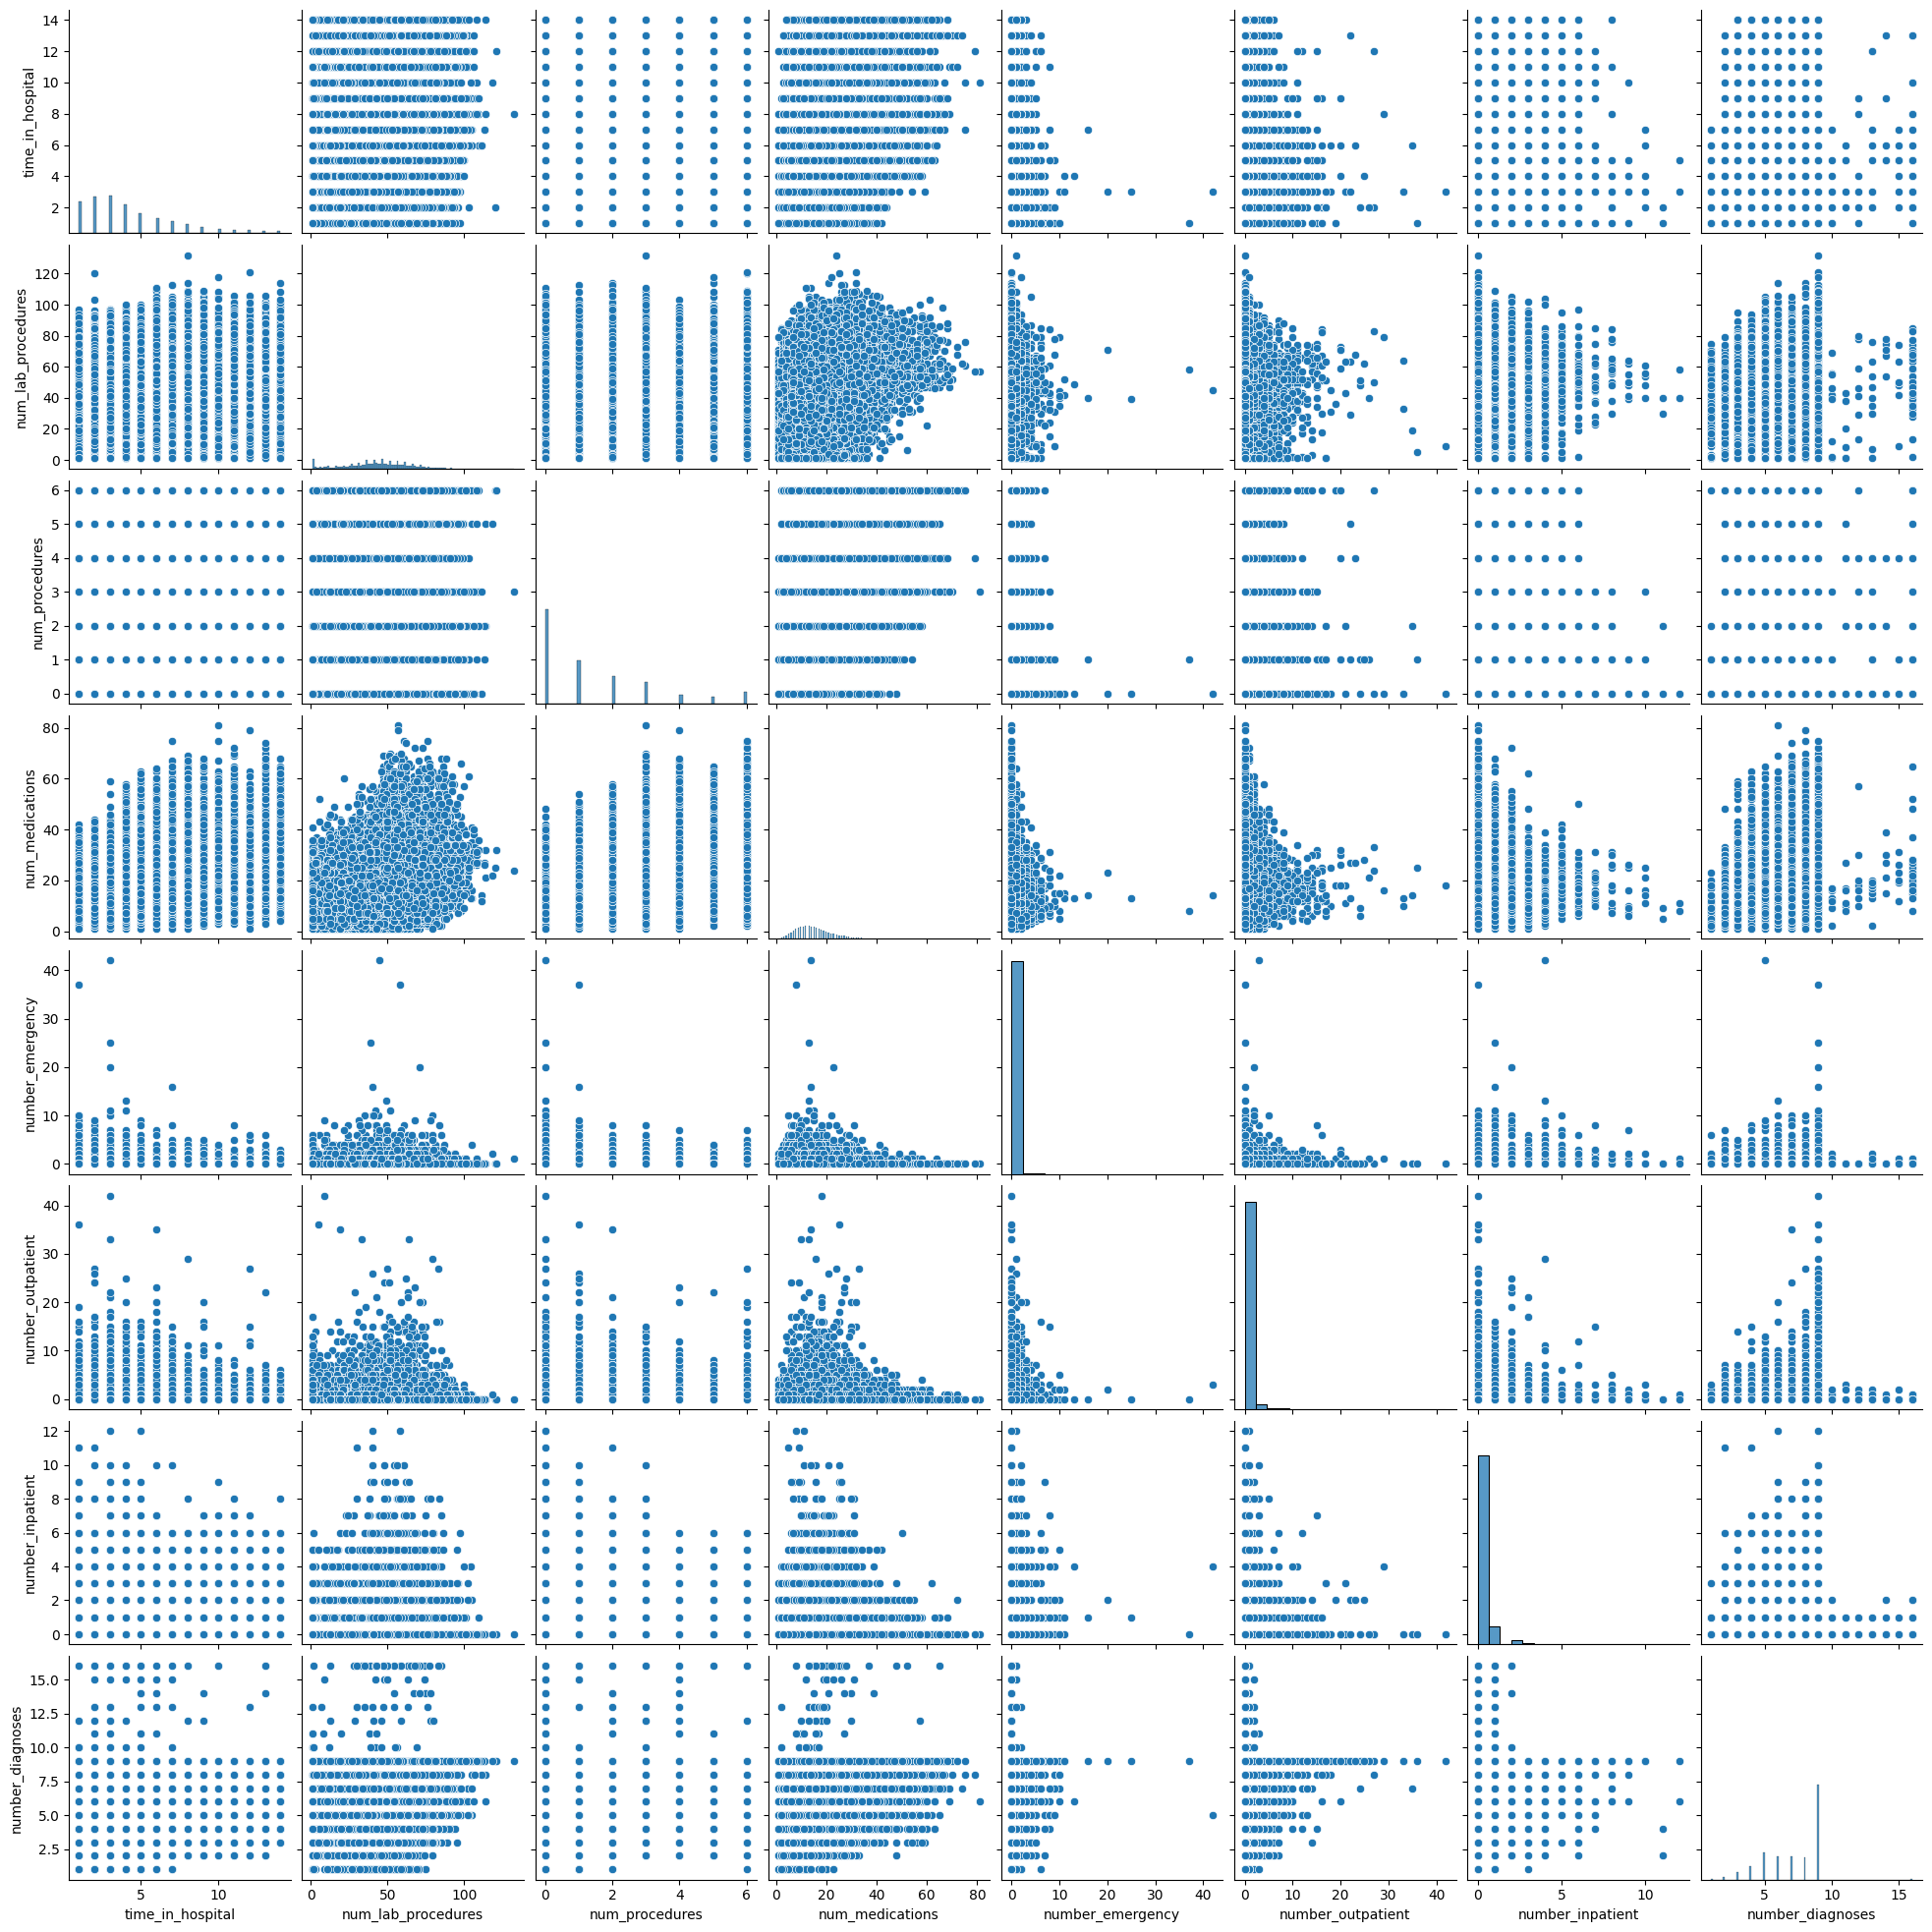

In [23]:
sns.pairplot(data_plot)

## Dividing the data into the training and testing datasets

In [23]:
# using 80 for train, 20 for test
print(len(data))
print(len(data)*0.2)

71518
14303.6


In [24]:
pop = list(np.arange(0,71518))
test_loc = random.sample(pop, k = 14304)
test = data.iloc[test_loc]
test.index = np.arange(0, 14304)

In [25]:
train_loc = list(set(pop) - set(test_loc))
train = data.iloc[train_loc]
train.index = np.arange(0, 57214)

In [26]:
test.to_csv('test_csv')

In [27]:
train.to_csv('train.csv')